## Action Planning with HRRs in a Nengo Model
This a notebook for cataloguing work towards a model that is able to plan, given some overall goal, a series of actions that bring about the goal. To start, we define a couple of vocabularies that contain representations of the possible action effects, actions, and action preconditions. Overall goals are generally action effects, and intermediate goals are generally action preconditions. 

In [1]:
import numpy as np
import nengo 
from nengo import spa
import matplotlib.pyplot as plt
%matplotlib inline

D = 256

effects = ['WATER_IN_KETTLE', 'KETTLE_UNDER_TAP', 'WATER_BOILED', 'KETTLE_PLUGGED_IN', 'KETTLE_UNPLUGGED']
action_set = ['FILL_KETTLE_FROM_TAP', 'PUT_KETTLE_UNDER_TAP', 'BOIL_KETTLE', 'PLUG_IN_KETTLE','UNPLUG_KETTLE']
precons = ['KETTLE_UNDER_TAP','KETTLE_UNPLUGGED','WATER_IN_KETTLE','HAS_CORD']

effect_vocab = spa.Vocabulary(D)
action_vocab = spa.Vocabulary(D)
precon_vocab = spa.Vocabulary(D)

# Cycle of control signals
cycle_items = ['GET_ACTION','GET_PRECON','SET_GOAL']
cycle_vocab = spa.Vocabulary(D)

for item in cycle_items:
    cycle_vocab.parse(item)

for effect in effects:
    effect_vocab.parse(effect)
    
for action in action_set:
    action_vocab.parse(action)

for precon in precons:
    precon_vocab.parse(precon)
    
action_vocab['INDEX'].make_unitary()

In [2]:
def plot_results(sim):
    fig = plt.figure(figsize=(16,8))

    p1 = fig.add_subplot(4,1,1)
    p1.plot(sim.trange(), model.similarity(sim.data, goal_probe))
    p1.legend(model.get_output_vocab('goal').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=6)
    p1.set_ylabel('Goal')

    p2 = fig.add_subplot(4,1,2)
    p2.plot(sim.trange(), model.similarity(sim.data, plan_probe))
    p2.legend(model.get_output_vocab('ctrl_sig').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=6)
    p2.set_ylabel('Control Signal')

    p3 = fig.add_subplot(4,1,3)
    p3.plot(sim.trange(), model.similarity(sim.data, action_probe))
    p3.legend(model.get_output_vocab('action').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=6)
    p3.set_ylabel('Actions')

    p4 = fig.add_subplot(4,1,4)
    p4.plot(sim.trange(), model.similarity(sim.data, precon_probe))
    p4.legend(model.get_output_vocab('goal').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=6)
    p4.set_ylabel('Preconditions')

    fig.subplots_adjust(hspace=0.75)
    plt.show()

Now we can define a nengo model that implements the planning. To start, we'll just implement a model that generates a sequence of subgoals given an overall goal, by iteratively inferring the preconditions of the actions that bring about the most recent subgoal in the sequence.

In [3]:
with spa.SPA(label='Effect Cleanup Test') as model:

    # Generate sequence of goals to push to stack
    model.ctrl_sig = spa.Memory(dimensions=D, vocab=cycle_vocab, synapse=0.01, tau=0.06) 
    model.goal = spa.Memory(dimensions=D, vocab=effect_vocab, synapse=0.01, tau=0.05)
    model.action = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.01, tau=0.05)
    model.precon = spa.Memory(dimensions=D, vocab=precon_vocab, synapse=0.01, tau=0.05)

    model.action_to_precon = spa.AssociativeMemory(input_vocab=action_vocab, output_vocab=precon_vocab, 
                                                 input_keys=action_set[:4], output_keys=precons, 
                                                 threshold=0.3)
    
    model.goal_to_action = spa.AssociativeMemory(input_vocab=effect_vocab, output_vocab=action_vocab, 
                                                   input_keys=effects, output_keys=action_set, 
                                                   threshold=0.3)

    actions = spa.Actions(
        'dot(ctrl_sig, GET_ACTION)  -->  goal_to_action=goal, ctrl_sig=GET_PRECON',
        'dot(ctrl_sig, GET_PRECON)  -->  action_to_precon=action, ctrl_sig=SET_GOAL',
        'dot(ctrl_sig, SET_GOAL)    -->  goal=precon, ctrl_sig=GET_ACTION')

    model.bg = spa.BasalGanglia(actions)
    model.thal = spa.Thalamus(model.bg)

    def set_goal(t):
        if 0.05 < t < 0.1: return 'WATER_BOILED'
        else: return '0'

    def set_plan(t):
        if 0.1 < t < 0.15: return 'GET_ACTION'
        else: return '0'

    model.goal_inp = spa.Input(goal=set_goal)
    model.plan_inp = spa.Input(ctrl_sig=set_plan)

    nengo.Connection(model.action_to_precon.output, model.precon.state.input)
    nengo.Connection(model.goal_to_action.output, model.action.state.input)

    goal_probe = nengo.Probe(model.goal.state.output, synapse=0.03)
    plan_probe = nengo.Probe(model.ctrl_sig.state.output, synapse=0.03)
    action_probe = nengo.Probe(model.action.state.output, synapse=0.03)
    precon_probe = nengo.Probe(model.precon.state.output, synapse=0.03)

sim = nengo.Simulator(model)

Here are some initial results. The representations plotted in the 'Actions' component of the graph will be pushed onto a stack in a more complete implementatino (to store the plan the model intends to execute). 

Simulation finished in 0:00:13.                                                 


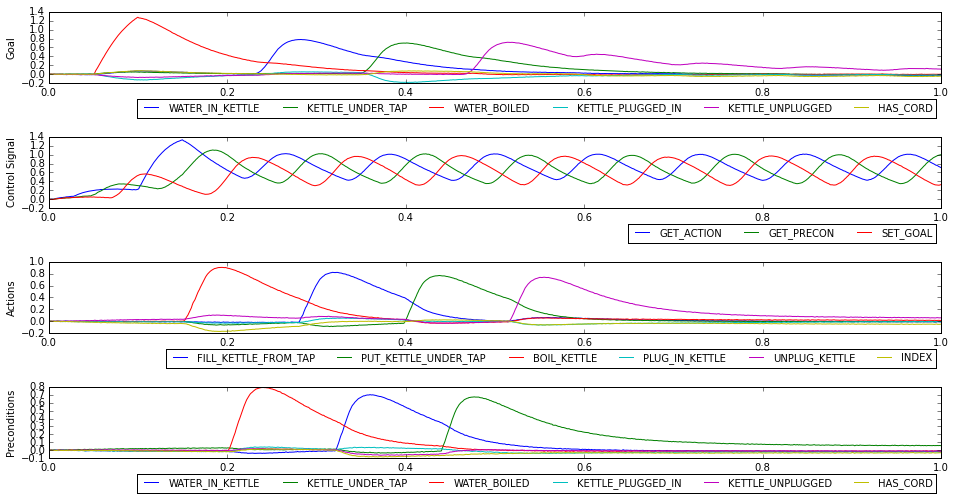

In [4]:
sim.reset()
sim.run(1)
plot_results(sim)

Now, we can define a revised model that actually implements the stack. 

In [35]:
with spa.SPA(label='Stack Test') as model:

    # For producing sequence of goals to push to stack
    model.ctrl_sig = spa.Memory(dimensions=D, vocab=cycle_vocab, synapse=0.01, tau=0.06) 
    model.goal = spa.Memory(dimensions=D, vocab=effect_vocab, synapse=0.01, tau=0.05)
    model.action = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.01, tau=0.05)
    model.precon = spa.Memory(dimensions=D, vocab=precon_vocab, synapse=0.01, tau=0.05)

    model.action_to_precon = spa.AssociativeMemory(input_vocab=action_vocab, output_vocab=precon_vocab, 
                                                 input_keys=action_set[:4], output_keys=precons, 
                                                 threshold=0.3)
    
    model.goal_to_action = spa.AssociativeMemory(input_vocab=effect_vocab, output_vocab=action_vocab, 
                                                   input_keys=effects, output_keys=action_set, 
                                                   threshold=0.3)

    # Stack implementation
    model.push = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.01,tau=0.025)
    model.stack = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.01, tau=0.15)
    model.top = spa.Memory(dimensions=D, vocab=action_vocab, synapse=0.01, tau=0.1)
    model.clean = spa.AssociativeMemory(action_vocab, threshold=0.12)

    actions = spa.Actions(
        'dot(ctrl_sig, GET_ACTION)     -->  goal_to_action=goal, ctrl_sig=GET_PRECON',
        'dot(ctrl_sig, GET_PRECON)     -->  action_to_precon=action, push=stack*INDEX+action, ctrl_sig=SET_GOAL',
        'dot(ctrl_sig, SET_GOAL)       -->  goal=precon, stack=push, ctrl_sig=GET_ACTION',
        'dot(ctrl_sig, TOP_ACTION)     -->  clean=stack, ctrl_sig=POP_ACTION',
        'dot(ctrl_sig, POP_ACTION)     -->  push=(stack-top)*~INDEX, ctrl_sig=UPDATE',
        'dot(ctrl_sig, UPDATE)         -->  stack=15*push, ctrl_sig=TOP_ACTION')
    
    model.bg = spa.BasalGanglia(actions)
    model.thal = spa.Thalamus(model.bg)

    def set_goal(t):
        if 0.075 < t < 0.1: return 'WATER_BOILED'
        else: return '0'

    def set_plan(t):
        if 0.1 < t < 0.15: return 'GET_ACTION'
        if 0.58 < t < 0.63: return '6*NULL'
        if 0.65 < t < 0.7: return 'TOP_ACTION'
        else: return '0'

    model.goal_inp = spa.Input(goal=set_goal)
    model.plan_inp = spa.Input(ctrl_sig=set_plan)

    nengo.Connection(model.action_to_precon.output, model.precon.state.input)
    nengo.Connection(model.goal_to_action.output, model.action.state.input)
    nengo.Connection(model.clean.output, model.top.state.input)

    goal_probe = nengo.Probe(model.goal.state.output, synapse=0.03)
    plan_probe = nengo.Probe(model.ctrl_sig.state.output, synapse=0.03)
    action_probe = nengo.Probe(model.action.state.output, synapse=0.03)
    precon_probe = nengo.Probe(model.precon.state.output, synapse=0.03)
    top_probe = nengo.Probe(model.top.state.output, synapse=0.03)
    stack_probe = nengo.Probe(model.stack.state.output, synapse=0.03)
    push_probe = nengo.Probe(model.push.state.output, synapse=0.03)
    
sim = nengo.Simulator(model, seed=np.random.randint(1))

In [36]:
def plot_results_full(sim):
    fig = plt.figure(figsize=(18,12))

    p1 = fig.add_subplot(7,1,1)
    p1.plot(sim.trange(), model.similarity(sim.data, goal_probe))
    p1.legend(model.get_output_vocab('goal').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=6)
    p1.set_ylabel('Goal')

    p2 = fig.add_subplot(7,1,2)
    p2.plot(sim.trange(), model.similarity(sim.data, plan_probe))
    p2.legend(model.get_output_vocab('ctrl_sig').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=7)
    p2.set_ylabel('Control Signal')

    p3 = fig.add_subplot(7,1,3)
    p3.plot(sim.trange(), model.similarity(sim.data, action_probe))
    p3.legend(model.get_output_vocab('action').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=6)
    p3.set_ylabel('Actions')

    p4 = fig.add_subplot(7,1,4)
    p4.plot(sim.trange(), model.similarity(sim.data, precon_probe))
    p4.legend(model.get_output_vocab('precon').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=6)
    p4.set_ylabel('Preconditions')

    p5 = fig.add_subplot(7,1,5)
    p5.plot(sim.trange(), model.similarity(sim.data, push_probe))
    p5.legend(model.get_output_vocab('push').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=6)
    p5.set_ylabel('Push')

    p6 = fig.add_subplot(7,1,6)
    p6.plot(sim.trange(), model.similarity(sim.data, stack_probe))
    p6.legend(model.get_output_vocab('stack').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=6)
    p6.set_ylabel('Stack')

    p7 = fig.add_subplot(7,1,7)
    p7.plot(sim.trange(), model.similarity(sim.data, top_probe))
    p7.legend(model.get_output_vocab('top').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=6)
    p7.set_ylabel('Execute')
    
    fig.subplots_adjust(hspace=0.75)
    plt.show()

Simulation finished in 0:00:38.                                                 


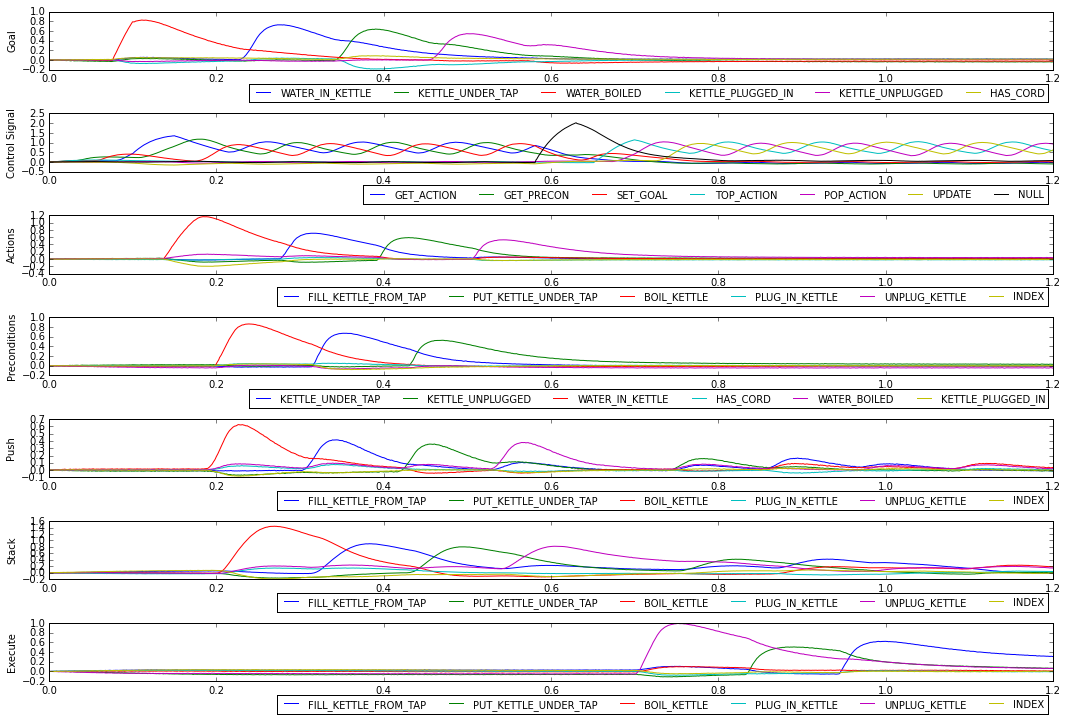

In [37]:
sim.reset()
sim.run(1.2)
plot_results_full(sim)